In [1]:
import torch
import torchvision
import torch.nn as nn
from IPython.display import Markdown, display
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("src/")

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")


Device: mps


In [2]:
""" # It's not working!

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from dotenv import load_dotenv

TRAIN_SIZE = 100
VAL_SIZE = 10
BATCH_SIZE = 8

torch.manual_seed(1)
load_dotenv()

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor() 
])
transform_validation = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])

def check_range(tensor):
    return (tensor.min() >= 0) and (tensor.max() <= 1)

def prepare_dataset(train_size=10,test_size=10,batch_size=8):
    login_token = os.getenv('HUGGING_FACE_TOKEN')
    dataset_train = load_dataset("imagenet-1k",split='train',use_auth_token=login_token,streaming=True)
    dataset_validation = load_dataset("imagenet-1k",split='test',use_auth_token=login_token,streaming=True)
    
    # map resize transformation before take 
    transformed_train = dataset_train.map(lambda x: {'image': transform_train(x['image']), 'grayscale_image': transform_validation(x['image']),'label': torch.tensor(x['label'])})
    transformed_test = dataset_validation.map(lambda x: {'image': transform_validation(x['image']),'label': torch.tensor(x['label'])})
    
    # shuffle train dataset
    transformed_train = transformed_train.shuffle()
 
    print("Dataset loaded successfully")
    return transformed_train.take(train_size),transformed_test.take(test_size)

class RecreationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        return {'image': image}
        
def prepare_dataloader(train_data,test_data,batch_size=4):
    
    # prepare data loader
    list_train_data = list(train_data)
    # filter out 1 channel images
    train_data = list(filter(lambda x: x['image'].shape[0] == 3, list_train_data))

    colorization_dataset_train = RecreationDataset(train_data)
    colorization_dataloader_train = DataLoader(colorization_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

    colorization_dataset_validation = RecreationDataset(list(test_data), test=True)
    colorization_dataloader_validation = DataLoader(colorization_dataset_validation, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print("Data loader prepared successfully")
    return colorization_dataloader_train, colorization_dataloader_validation

train_data, validation_data = prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE)
train_loader, validation_loader = prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)
 """

' # It\'s not working!\n\nfrom datasets import load_dataset\nfrom torch.utils.data import Dataset, DataLoader\nfrom PIL import Image\nfrom dotenv import load_dotenv\n\nTRAIN_SIZE = 100\nVAL_SIZE = 10\nBATCH_SIZE = 8\n\ntorch.manual_seed(1)\nload_dotenv()\n\ntransform_train = torchvision.transforms.Compose([\n    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),\n    torchvision.transforms.ToTensor() \n])\ntransform_validation = torchvision.transforms.Compose([\n    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),\n    torchvision.transforms.ToTensor(),\n])\n\ndef check_range(tensor):\n    return (tensor.min() >= 0) and (tensor.max() <= 1)\n\ndef prepare_dataset(train_size=10,test_size=10,batch_size=8):\n    login_token = os.getenv(\'HUGGING_FACE_TOKEN\')\n    dataset_train = load_dataset("imagenet-1k",split=\'train\',use_auth_token=login_token,streaming=True)\n    dataset_validation = load_dataset("imagenet-1k",split=\'test\',use_auth_toke

In [21]:
TRAIN_SIZE = 1200
VAL_SIZE = 10
BATCH_SIZE = 8

from dataset import prepare_dataset, prepare_dataloader

train_data, validation_data = prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE)
train_loader, validation_loader = prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)

Dataset loaded successfully
Data loader prepared successfully


In [23]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        
        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)


    def forward(self,x):
        x=x.to(device)
        # Encoder
        conv1 = self.conv1(x)
        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)
        
        # Decoder
        concatenation_5to6 = torch.cat((conv4, self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)
        
        concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output
    
    def train_model(self, train_loader, val_loader, epochs=10, lr=0.001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True):
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            for i, batch_data in enumerate(train_loader):
                image = batch_data['image']
                image = image.to(device)
                optimizer.zero_grad()
                reproduced_image = self(image)
                reproduced_image = reproduced_image.to(device)
                loss = loss_fn(reproduced_image, image)
                loss.backward()
                optimizer.step()
                if verbose and i % 100 == 0:
                    print(f"Epoch {epoch}, iter {i}: loss = {loss.item()}")

            if (epoch + 1) % (epochs//10) == 0 or (epoch + 1) == epochs:
                state_diction = self.state_dict()
                for key in state_diction.keys():
                    state_diction[key] = state_diction[key].to(torch.device('cpu'))
                torch.save(state_diction, "./model_storage/UNet_iter_{:d}.pth.tar".format(i + 1))

net=UNet()

In [24]:
net.train_model(train_loader=train_loader, val_loader=validation_loader, epochs=100, lr=0.001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, iter 0: loss = 0.6031601428985596
Epoch 0, iter 100: loss = 0.03478756919503212


  1%|          | 1/100 [28:59<47:49:54, 1739.34s/it]

Epoch 1, iter 0: loss = 0.006358311511576176


  1%|          | 1/100 [44:45<73:51:25, 2685.72s/it]


KeyboardInterrupt: 

In [20]:
net.load_state_dict(torch.load("./model_storage/UNet_iter_13.pth.tar"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
L shape torch.Size([128, 128])


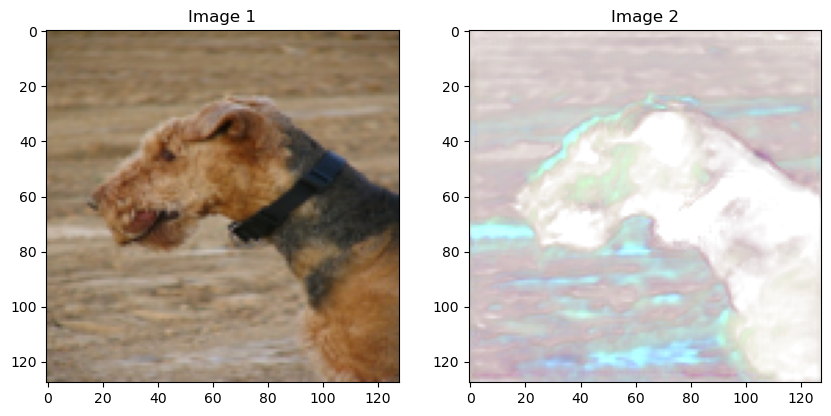

In [7]:
import matplotlib.pyplot as plt

def plot_both(image1,image2):
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, recreated_image):
    print(original_image.shape)
    print(recreated_image.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),recreated_image),0)

def visualize(image,model):
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu()
    output = compose_output(image,output[0])

    plot_both(image.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())

visualize(list(train_data)[17]['image'],net)